# Preference Learning Report Visualizations

Explore the saved `metrics.json` artifacts for each persona/dataset/model run, aggregate them into convenient tables, and generate visual summaries (precision/recall/Jaccard, rank correlations, etc.).

In [1]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

RESULTS_ROOT = Path('../../results') / 'full_run_dec8' / 'preference_learning'
PLOT_STYLE = dict(s=80, alpha=0.7, edgecolor='black')

sns.set_theme(style='whitegrid')


In [2]:
def load_metrics(root: Path = RESULTS_ROOT) -> pd.DataFrame:
    records: List[Dict[str, object]] = []
    for persona_dir in sorted(root.iterdir()):
        if not persona_dir.is_dir():
            continue
        persona = persona_dir.name
        for experiment_dir in sorted(persona_dir.iterdir()):
            metrics_path = experiment_dir / 'metrics.json'
            summary_path = experiment_dir / 'summary.json'
            if not metrics_path.exists() or not summary_path.exists():
                continue
            summary = json.loads(summary_path.read_text())
            with metrics_path.open('r') as handle:
                metrics = json.load(handle)
            dataset_name = summary.get('dataset')
            model_name = summary.get('model')
            for instance_id, payload in metrics.items():
                gt = payload.get('ground_truth', [])
                for k, stats in (payload.get('top_k') or {}).items():
                    rank_corr = stats.get('rank_correlation') or {}
                    records.append(
                        {
                            'persona': persona,
                            'dataset': dataset_name,
                            'model': model_name,
                            'experiment': experiment_dir.name,
                            'instance_id': int(instance_id),
                            'k': int(k),
                            'hits': stats.get('hits', 0.0),
                            'precision': stats.get('precision', 0.0),
                            'recall': stats.get('recall', 0.0),
                            'jaccard': stats.get('jaccard', 0.0),
                            'spearman': rank_corr.get('spearman', 0.0),
                            'kendall': rank_corr.get('kendall', 0.0),
                            'ground_truth_size': len(gt),
                        }
                    )
    return pd.DataFrame(records)

metrics_df = load_metrics()
print(f'Loaded {len(metrics_df)} metric rows from {metrics_df.experiment.nunique()} experiments.')
metrics_df.head()


Loaded 576 metric rows from 12 experiments.


,persona,dataset,model,experiment,instance_id,k,hits,precision,recall,jaccard,spearman,kendall,ground_truth_size
0,layperson,open_compas,decision_tree,open_compas__decision_tree_pareto,133,1,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,14
1,layperson,open_compas,decision_tree,open_compas__decision_tree_pareto,133,3,2.0,0.666667,0.666667,0.500000,0.200000,0.000000,14
2,layperson,open_compas,decision_tree,open_compas__decision_tree_pareto,133,5,4.0,0.800000,0.800000,0.666667,0.485714,0.333333,14
3,layperson,open_compas,decision_tree,open_compas__decision_tree_pareto,609,1,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,11
4,layperson,open_compas,decision_tree,open_compas__decision_tree_pareto,609,3,3.0,1.000000,1.000000,1.000000,1.000000,1.000000,11


In [3]:
def compact_name(name: str) -> str:
    parts = [part for part in name.split('_') if part]
    if len(parts) <= 2:
        trimmed = parts
    else:
        trimmed = parts[1:-1]
    return '_'.join(part[0] for part in trimmed if part)

with pd.option_context('mode.chained_assignment', None):
    metrics_df['experiment_short'] = metrics_df['experiment'].apply(compact_name)


In [4]:
agg_metrics = (
    metrics_df
    .groupby(['persona', 'dataset', 'model', 'experiment_short', 'k'])
    [['precision', 'recall', 'jaccard', 'spearman', 'kendall']]
    .mean()
    .reset_index()
)
agg_metrics.head()


,persona,dataset,model,experiment_short,k,precision,recall,jaccard,spearman,kendall
0,layperson,open_compas,decision_tree,c_d_t,1,0.625000,0.625000,0.625000,-0.375000,-0.375000
1,layperson,open_compas,decision_tree,c_d_t,3,0.833333,0.833333,0.775000,0.550000,0.475000
2,layperson,open_compas,decision_tree,c_d_t,5,0.900000,0.900000,0.833333,0.685714,0.616667
3,layperson,open_compas,gradient_boosting,c_g_b,1,0.750000,0.750000,0.750000,-0.250000,-0.250000
4,layperson,open_compas,gradient_boosting,c_g_b,3,0.916667,0.916667,0.875000,0.350000,0.291667


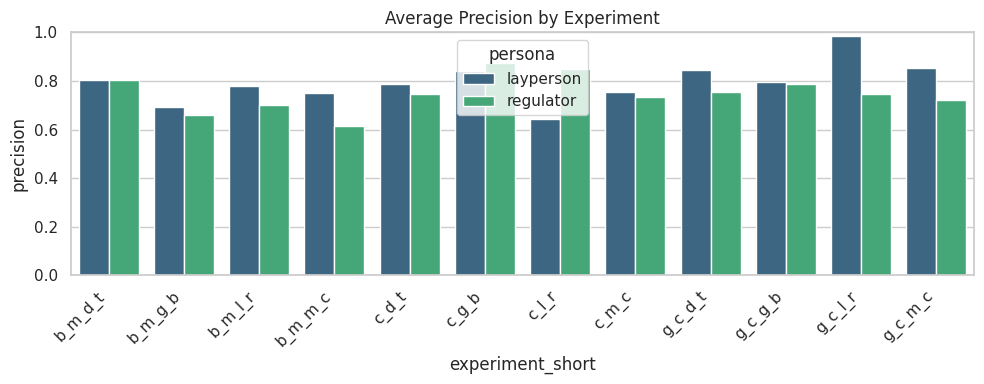

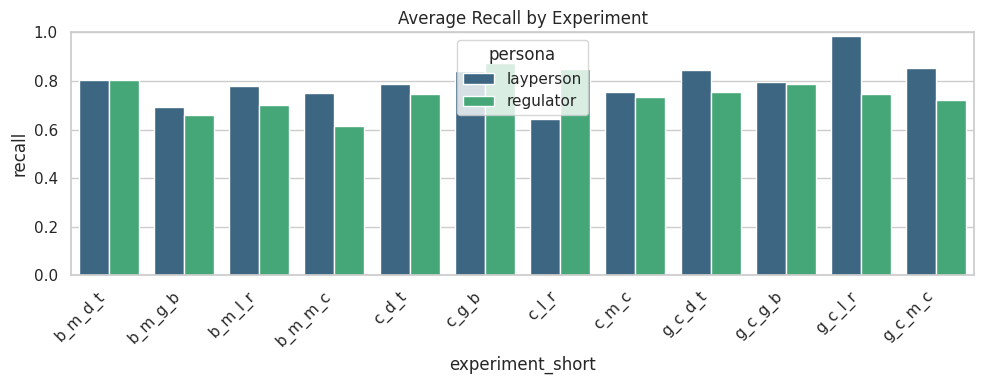

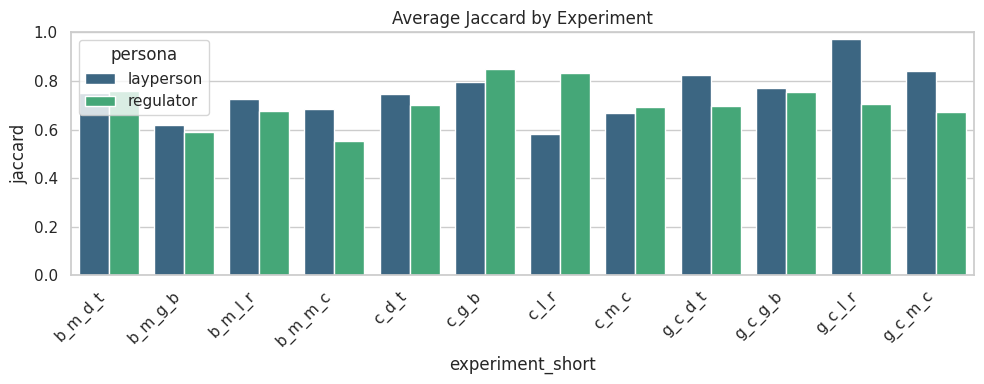

In [5]:
def plot_bar(metric: str, data: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 4))
    sns.barplot(
        data=data,
        x='experiment_short',
        y=metric,
        hue='persona',
        palette='viridis',
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(f'Average {metric.title()} by Experiment')
    plt.tight_layout()

plot_bar_data = (
    metrics_df.groupby(['persona', 'experiment_short'])[['precision', 'recall', 'jaccard']]
    .mean()
    .reset_index()
)
for metric in ['precision', 'recall', 'jaccard']:
    plot_bar(metric, plot_bar_data)
    plt.show()


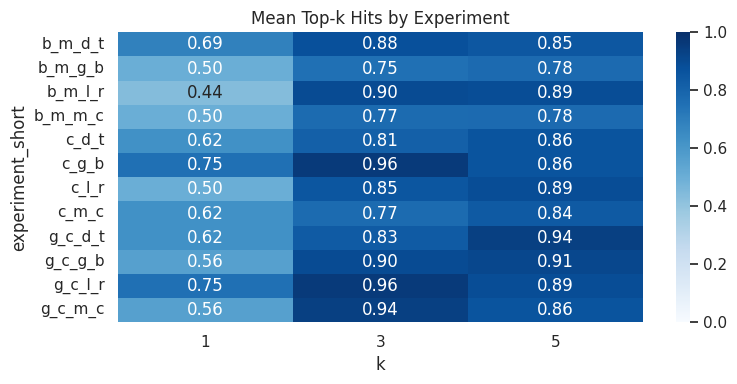

In [11]:
# heatmap_df = (
#     metrics_df.pivot_table(
#         index='experiment_short',
#         columns='k',
#         values='hits',
#         aggfunc='mean'
#     )
# )

heatmap_df = (
    metrics_df.pivot_table(
        index='experiment_short',
        columns='k',
        values='precision',  # or 'recall' / 'jaccard'
        aggfunc='mean',
    )
)
plt.figure(figsize=(8, max(4, len(heatmap_df) * 0.3)))
sns.heatmap(heatmap_df, annot=True, fmt='.2f', vmin=0, vmax=1, cmap='Blues')
plt.title('Mean Top-k Hits by Experiment')
plt.tight_layout()
plt.show()


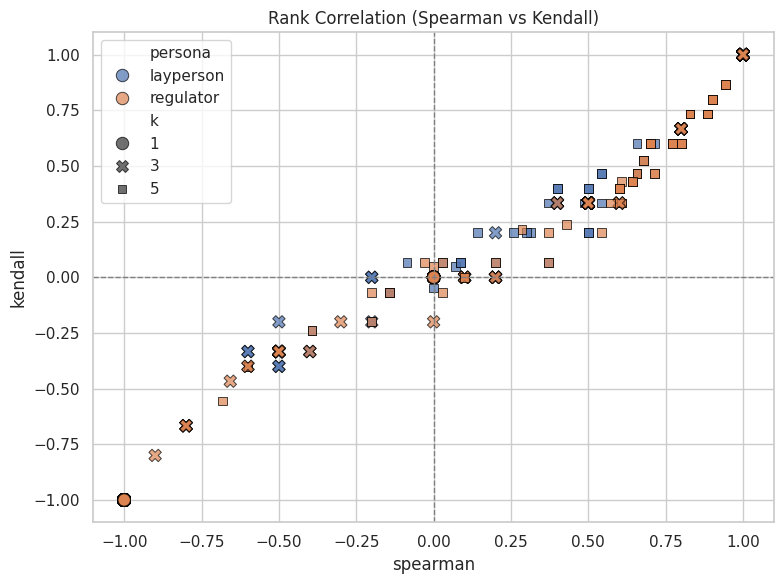

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=metrics_df,
    x='spearman',
    y='kendall',
    hue='persona',
    style='k',
    palette='deep',
    **PLOT_STYLE,
)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Rank Correlation (Spearman vs Kendall)')
plt.tight_layout()
plt.show()
